In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

In [2]:
def GenerateLinearTrajectory(seqLen=252, stateDim=2, vel=None, start=None, dt=0.1):
    if start is None:
        start = torch.rand(stateDim) * 2 - 1
    if vel is None:
        vel = torch.rand(stateDim) * 2 - 1
    traj = []
    pos = start.clone()
    for _ in range(seqLen):
        traj.append(pos.clone())
        pos = pos + vel * dt
    traj = torch.stack(traj, dim=0)
    noise = torch.randn_like(traj) * 0.01
    traj = traj + noise
    return traj

In [3]:
"""
x = x1 + t * (x2 - x1)
y = y1 + t * (y2 - y1)
z = z1 + t * (z2 - z1)
"""

def MakeTrajectoryToSize(trajectory, reSize):
    # Add Extra points to trajectory by first select two random points in sequence
    # and then find the point at line created by two points
    seqTraj = []
    for row in trajectory:
        seqTraj.append(row)
    curShape = trajectory.shape
    numberOfPoints = reSize - curShape[0]
    for i in range(numberOfPoints):
        t = torch.randint(0, curShape[0] - 1, (1,)).item()
        newTensor = torch.tensor([(seqTraj[t][0] + seqTraj[t + 1][0])/2, seqTraj[t][1] + 0.5 * (seqTraj[t + 1][1] - seqTraj[t][1]), seqTraj[t][2] + 0.5 * (seqTraj[t + 1][2] - seqTraj[t][2]), seqTraj[t][3] + 0.5 * (seqTraj[t + 1][3] - seqTraj[t][3])])
        seqTraj.insert(t + 1, newTensor)
    return torch.stack(seqTraj, dim=0)


In [4]:
a = torch.rand(300, 4)
MakeTrajectoryToSize(a, 252).shape

torch.Size([300, 4])

In [5]:
class DataSet:
    def __init__(self):
        self.trajectory = [GenerateLinearTrajectory() for _ in range(500)]

    def Show2D(self, index, giveTraj=None, points = []):
        if giveTraj is None:
            trajToPlot = self.trajectory[index]
        else:
            trajToPlot = giveTraj        
        x = trajToPlot[:, 0]
        y = trajToPlot[:, 1]        
        plt.figure(figsize=(8, 6))
        for pnt in points:
            plt.scatter(np.array(pnt[0]), np.array(pnt[1]), color="purple", s=80, label="Obstacles")
        plt.plot(x.numpy(), y.numpy(), marker="o", markersize=2, color="blue", label="Trajectory")        
        plt.scatter(x[0], y[0], color="green", s=80, label="Start")

        plt.scatter(x[-1], y[-1], color="red", s=80, label="Goal")

        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("Drone Trajectory in 2D")
        plt.legend()
        plt.grid(True)
        plt.show()


In [6]:
def SinusoidalTimeEmbedding(timesteps, dim):
    device = timesteps.device
    half = dim // 2
    freqs = torch.exp(-torch.arange(0, half, dtype=torch.float32, device=device) * (torch.log(torch.tensor(10000.0)) / (half - 1)))
    args = timesteps.float().unsqueeze(1) * freqs.unsqueeze(0)
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=1)
    if dim % 2 == 1:
        emb = torch.cat([emb, torch.zeros((emb.shape[0],1), device=device)], dim=1)
    return emb

In [18]:
class UNet(nn.Module):
    def __init__(self, stateDim, hiddenDim=128):
        super().__init__()
        self.conv1 = nn.Conv1d(stateDim, hiddenDim, 3, padding=1)
        self.conv2 = nn.Conv1d(hiddenDim, hiddenDim * 2, 3, stride=2, padding=1)
        self.conv3 = nn.Conv1d(hiddenDim * 2, hiddenDim * 4, 3, stride=2, padding=1)
        self.convMid = nn.Conv1d(hiddenDim * 4, hiddenDim * 4, 3, padding=1)
        self.deconv1 = nn.ConvTranspose1d(hiddenDim * 4, hiddenDim * 2, 4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose1d(hiddenDim * 2, hiddenDim, 4, stride=2, padding=1)
        self.convOut = nn.Conv1d(hiddenDim, stateDim, 3, padding=1)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.timeEmbd = nn.Sequential(
            nn.Linear(hiddenDim * 2, hiddenDim*4),
            nn.SiLU(),
            nn.Linear(hiddenDim*4, hiddenDim*4)
        )

    def forward(self, x, t):
        x = x.permute(0, 2, 1)
        e1 = F.relu(self.conv1(x))
        e2 = F.relu(self.conv2(e1))
        e3 = F.relu(self.conv3(e2))

        tEmbd = SinusoidalTimeEmbedding(t, self.timeEmbd[0].in_features)
        tFeat = self.timeEmbd(tEmbd).unsqueeze(-1)
        e3 = e3 + tFeat

        b = F.relu(self.convMid(e3))
        d1 = F.relu(self.deconv1(b))
        d2 = F.relu(self.deconv2(d1 + e2))
        out = self.convOut(d2 + e1)
        
        return out.permute(0, 2, 1)

In [19]:
class Diffusion:
    def __init__(self):
        self.dataset = DataSet()
        self.T = 1000
        self.alphaBar,self.beta = self.CreateAlpha()

    def CreateAlpha(self):
        beta = torch.linspace(1e-4, 0.02, self.T)
        alpha = 1 - beta
        return torch.cumprod(alpha, dim=0),beta

    def ForwardDiffusion(self, x0, t): 
        alpha = self.alphaBar[t].view(x0.shape[0], 1, 1)
        eps = torch.randn_like(x0)
        return torch.sqrt(alpha) * x0 + torch.sqrt(1 - alpha) * eps, eps

def ReverseDiffusionModel(model, df, start, end):
    tau = torch.rand(1, 252, 2).to(model.device)
    for i in range(900, 0, -1):
        tau[0, 0] = start
        tau[0, -1] = end
        t = torch.full((1,), i, dtype=torch.long, device=model.device)        
        eps = model(tau, t)
        alphaBarT = df.alphaBar[i]
        betaT = df.beta[i]
        alphaT = 1 - betaT
        mean = (1 / torch.sqrt(alphaT)) * (tau - ((1 - alphaT) / torch.sqrt(1 - alphaBarT)) * eps)
        noise = torch.randn_like(tau)
        if(i > 0):
            tau = mean + torch.sqrt(betaT) * noise
        else:
            tau = mean
        
    tau[0, 0] = start
    tau[0, -1] = end
    return tau

In [20]:
class Train:
    def __init__(self):
        self.df = Diffusion()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.unet = UNet(stateDim=2).to(self.device)
        self.batchSize = 64
        self.lossFn = nn.MSELoss()
        self.optim = torch.optim.Adam(self.unet.parameters(), lr=1e-3)

    def Train(self, epoch = 1000):
        
        for epc in range(epoch):
            totalLoss = 0
            for index in range(self.batchSize, len(self.df.dataset.trajectory), self.batchSize):
                xT = torch.stack(self.df.dataset.trajectory[index - self.batchSize: index])
                t = torch.randint(0, self.df.T, (xT.shape[0],))
                noisyTraj ,noiseps = self.df.ForwardDiffusion(xT, t)
                input = noisyTraj.to(self.device).float()
                target = noiseps.to(self.device).float()
                t = t.to(self.device)

                output = self.unet(input, t)
                loss = self.lossFn(output, target)
                self.optim.zero_grad()
                loss.backward()
                totalLoss += loss.item()
                self.optim.step()
            print(f"Epoch : {epc}/{epoch} | Loss: {totalLoss}")

In [21]:
tr = Train()

In [29]:
tr.Train(epoch=100)

Epoch : 0/100 | Loss: 81.065031953156
Epoch : 1/100 | Loss: 42.39309084787965
Epoch : 2/100 | Loss: 39.422206457704306
Epoch : 3/100 | Loss: 38.02994471043348
Epoch : 4/100 | Loss: 36.116315472871065
Epoch : 5/100 | Loss: 35.26795845478773
Epoch : 6/100 | Loss: 34.92654864862561
Epoch : 7/100 | Loss: 34.58145505934954
Epoch : 8/100 | Loss: 33.99601062387228
Epoch : 9/100 | Loss: 33.333884578198195
Epoch : 10/100 | Loss: 33.1131243146956
Epoch : 11/100 | Loss: 32.62340756505728
Epoch : 12/100 | Loss: 32.357979133725166
Epoch : 13/100 | Loss: 32.60830336809158
Epoch : 14/100 | Loss: 32.12602832913399
Epoch : 15/100 | Loss: 31.9921182282269
Epoch : 16/100 | Loss: 32.11471254751086
Epoch : 17/100 | Loss: 32.17953058332205
Epoch : 18/100 | Loss: 32.0012932382524
Epoch : 19/100 | Loss: 31.725905019789934
Epoch : 20/100 | Loss: 31.529705699533224
Epoch : 21/100 | Loss: 31.694057691842318
Epoch : 22/100 | Loss: 31.533970844000578
Epoch : 23/100 | Loss: 31.458827197551727
Epoch : 24/100 | Loss:

In [ ]:
# torch.save(tr.unet.state_dict(), "test(10k)(2d).pth")

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(stateDim=2).to(device)
model.load_state_dict(torch.load("test(10k)(2d).pth", map_location=device))
model.eval()

UNet(
  (conv1): Conv1d(2, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(128, 256, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv3): Conv1d(256, 512, kernel_size=(3,), stride=(2,), padding=(1,))
  (convMid): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (deconv1): ConvTranspose1d(512, 256, kernel_size=(4,), stride=(2,), padding=(1,))
  (deconv2): ConvTranspose1d(256, 128, kernel_size=(4,), stride=(2,), padding=(1,))
  (convOut): Conv1d(128, 2, kernel_size=(3,), stride=(1,), padding=(1,))
  (timeEmbd): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
)

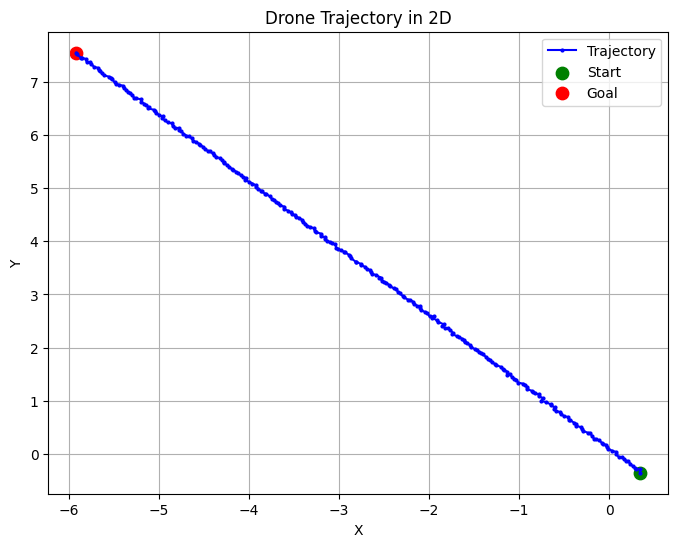

In [23]:
tr.df.dataset.trajectory[0].shape
tr.df.dataset.Show2D(1, tr.df.dataset.trajectory[10])

In [24]:
len(tr.df.dataset.trajectory)

500

In [25]:
tr.df.dataset.trajectory[100][0]

tensor([ 0.5711, -0.9923])

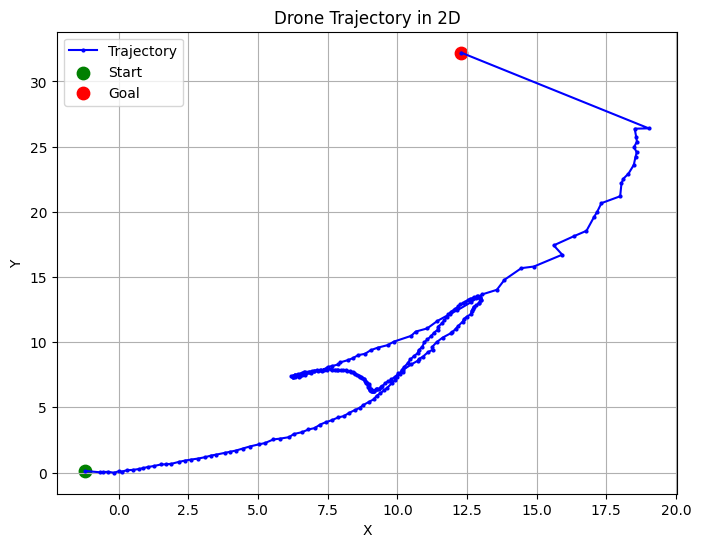

In [26]:
T = tr.df.alphaBar
traj = ReverseDiffusionModel(model, tr.df, start=torch.tensor([-1.21, 0.12]), end=torch.tensor([12.3, 32.2])).squeeze(0).cpu().detach()
tr.df.dataset.Show2D(1, traj)

## Update Reverse Diffusion Process

In [ ]:
import torch
import torch.nn as nn

class LossFunction(nn.Module):
    def __init__(self, w_smooth=3, w_space=1, w_length=6, w_collision=10, safety_radius=1.5):
        """
        Args:
            w_smooth: Weight for curvature penalty.
            w_space: Weight for equal spacing penalty.
            w_length: Weight for minimizing path length.
            w_collision: Weight for collision avoidance.
            safety_radius: The distance threshold. If trajectory is further 
                           than this from an obstacle, cost is 0.
        """
        super().__init__()
        self.w_smooth = w_smooth
        self.w_space = w_space
        self.w_length = w_length
        self.w_collision = w_collision
        self.safety_radius = safety_radius

    def forward(self, traj, obstacles=None):
        vel = traj[:, 1:] - traj[:, :-1]
        acc = vel[:, 1:] - vel[:, :-1]
        lossSmooth = (acc ** 2).sum()
        segmentLens = torch.norm(vel, dim=-1) + 1e-6
        meanLen = segmentLens.mean(dim=1, keepdim=True)
        lossSpace = ((segmentLens - meanLen) ** 2).sum()
        lossDistance = torch.norm(vel, dim=-1).sum()


        lossCollision = torch.tensor(0.0, device=traj.device)
        traj_xy = traj[0, :, :2]
        dists = torch.cdist(traj_xy, obstacles)
        diff = self.safety_radius - dists
        
        collision_mask = torch.nn.functional.relu(diff)
        lossCollision = (collision_mask ** 2).sum()


        tLoss = (self.w_smooth * lossSmooth) + \
                     (self.w_space * lossSpace) + \
                     (self.w_length * lossDistance) + \
                     (self.w_collision * lossCollision)
                     
        return tLoss


In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(stateDim=2).to(device)
model.load_state_dict(torch.load("test(10k)(2d).pth", map_location=device))
model.eval()

UNet(
  (conv1): Conv1d(2, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(128, 256, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv3): Conv1d(256, 512, kernel_size=(3,), stride=(2,), padding=(1,))
  (convMid): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (deconv1): ConvTranspose1d(512, 256, kernel_size=(4,), stride=(2,), padding=(1,))
  (deconv2): ConvTranspose1d(256, 128, kernel_size=(4,), stride=(2,), padding=(1,))
  (convOut): Conv1d(128, 2, kernel_size=(3,), stride=(1,), padding=(1,))
  (timeEmbd): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
)

In [78]:
def OptimizeTrajectory(tau, start, end, obs, iter = 2500, lr = 0.2,):    
    tau = tau.detach().clone().requires_grad_(True).to(device)
    sgdLoss = LossFunction()
    optimizer = torch.optim.Adam([tau], lr=lr)    
    for _ in range(iter):
        optimizer.zero_grad()
        tauLoss = sgdLoss(tau, obstacles=obs)    
        tauLoss.backward()
        optimizer.step()
        with torch.no_grad():            
            tau[0, 0] = start
            tau[0, -1] = end
    return tau

In [79]:
class Diffusion:
    def __init__(self):
        self.dataset = DataSet()
        self.T = 1000
        self.alphaBar,self.beta = self.CreateAlpha()

    def CreateAlpha(self):
        beta = torch.linspace(1e-4, 0.02, self.T)
        alpha = 1 - beta
        return torch.cumprod(alpha, dim=0),beta

    def ForwardDiffusion(self, x0, t): 
        alpha = self.alphaBar[t].view(x0.shape[0], 1, 1)
        eps = torch.randn_like(x0)
        return torch.sqrt(alpha) * x0 + torch.sqrt(1 - alpha) * eps, eps

def ReverseDiffusionModel(model, df, start, end, obst = []):
    tau = torch.rand(1, 252, 2).to(model.device)
    tau[0, 0] = start
    tau[0, -1] = end
    for i in tqdm(range(900, 0, -1)):
        t = torch.full((1,), i, dtype=torch.long, device=model.device)        
        eps = model(tau, t)
        alphaBarT = df.alphaBar[i]
        betaT = df.beta[i]
        alphaT = 1 - betaT
        mean = (1 / torch.sqrt(alphaT)) * (tau - ((1 - alphaT) / torch.sqrt(1 - alphaBarT)) * eps)
        noise = torch.randn_like(tau)
        if(i > 0):
            tau = mean + torch.sqrt(betaT) * noise
        else:
            tau = mean
        tau[0, 0] = start
        tau[0, -1] = end
        tau = OptimizeTrajectory(tau, start, end, iter=100, obs=torch.tensor(obst, device=device))
    tau = tau.detach()
    return tau

In [80]:
tr.df.dataset.trajectory[100][0]

tensor([ 0.5711, -0.9923])

100%|██████████| 900/900 [01:31<00:00,  9.87it/s]


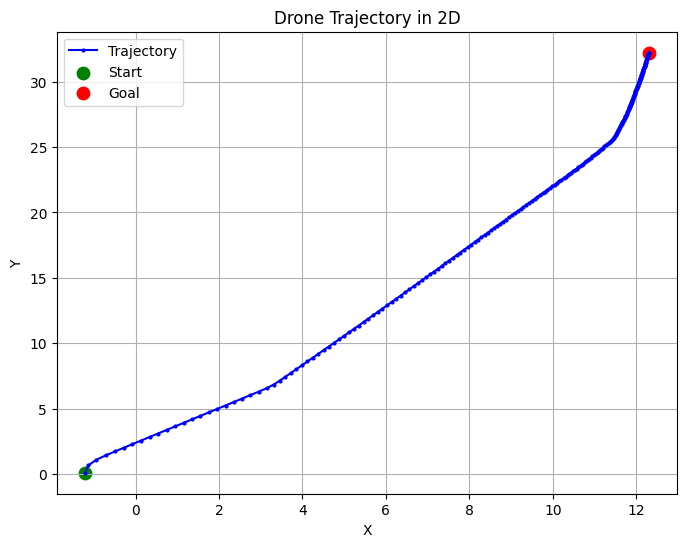

In [81]:
T = tr.df.alphaBar
startPoint = torch.tensor([-1.21, 0.12])
endPoint = torch.tensor([12.3, 32.2])
points = [[5.9, 6], [0, 0], [2, 7.5], [6, 17], [10, 26]]
traj = ReverseDiffusionModel(model, tr.df, start=startPoint, end=endPoint, obst=points).squeeze(0).cpu().detach()
tr.df.dataset.Show2D(1, traj)

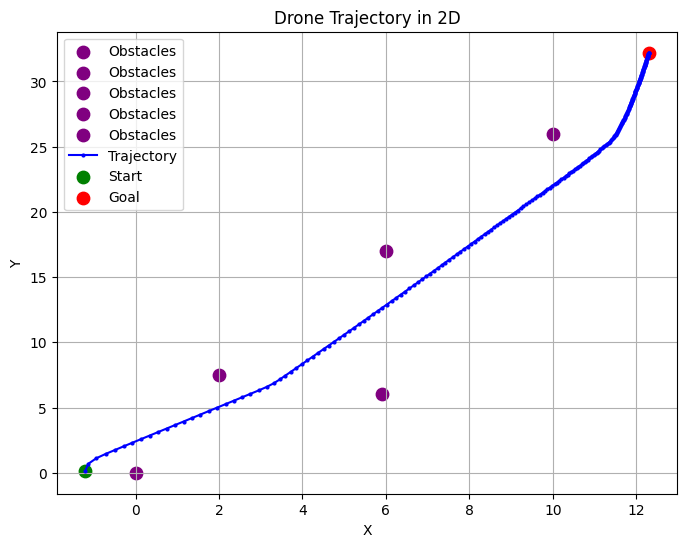

In [82]:
points = [[5.9, 6], [0, 0], [2, 7.5], [6, 17], [10, 26]]
tr.df.dataset.Show2D(1, traj, points)